In [2]:
#built in librairies 
from tqdm import tqdm

# pip libraires
import numpy as np
import json
import pandas as pd
from time import sleep
from random import randint
import csv
import datetime
import time
from utils.genres import additional_wordsets

# visualization librairies
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# Natural Language Processing Librairies
import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
import re
import spacy
from spacy import displacy
import spacy_transformers

# Visualization librairies
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Calculating libraries
import scipy as sp

#statistical librairies
import pingouin 

# Import libraries
import requests
from bs4 import BeautifulSoup
import pickle

# Others
from functools import partial
from ast import literal_eval

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Geopositioning and mapping
import geopandas as gpd 
import geopy 
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

# Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, State
import dash_leaflet as dl
import dash_leaflet.express as dlx
import dash
from dash_extensions.javascript import assign
from dash.exceptions import PreventUpdate


In [3]:
"""read table tvtropes and process the data to get rid of json format
"""
summaries=pd.read_csv('./data/plot_summaries.txt',sep="\t",header=None)
summaries.rename(columns={0:'wikipedia_movie_id',1:'Plot_summaries'},inplace=True)
movies=pd.read_table('./data/movie.metadata.tsv',header=None)
movies.rename(columns={0:'wikipedia_movie_id',1:'rebase_movie_ID',2:'Movie_name',3:'Movie_release',4:'Box_office_revenue',5:'Movie_runtime',6:'Movie_language',7:'Movie_country',8:'Movie_genre'},inplace=True)

df_summaries = pd.merge(summaries, movies[['wikipedia_movie_id', 'Movie_name']], on='wikipedia_movie_id')

In [4]:
# Read the country and sentiment information dataframe
df_summaries = pd.read_csv('data/country_sentiment_stitch.csv', index_col=0)
df_summaries[['who','where','country','sentiment']] = df_summaries[['who','where','country','sentiment']].applymap(literal_eval)

# Check if there are no errors
print(len(df_summaries))

42204


In [4]:
# Setup geocode and locator
user_agent = 'user_me_{}'.format(randint(10000,99999))
locator = Nominatim(user_agent=user_agent)
geocode = RateLimiter(locator.geocode, min_delay_seconds=1.2)

## Data formatting for plots

We first need to join information together in order to plot the desired information. We decided to do an analysis by country and not by location since we have more data by country and the results are better for our data story.

In [5]:
# Generate a copy for safety
movies_copy = movies.copy()

# Convert the release date to a year and merge with the summaries
movies_copy['Movie_release'] = pd.to_datetime(movies_copy['Movie_release'], errors = 'coerce').dt.year
df_summaries_dated = pd.merge(df_summaries, movies_copy[['wikipedia_movie_id', 'Movie_release', 'Movie_country', 'Movie_name']], on='wikipedia_movie_id')

# Extract the desired information from the dictionaries format of where, who, country and sentiment
df_summaries_dated['countries'] = df_summaries_dated['country'].apply(lambda x : list(x.keys()))
df_summaries_dated['where_key'] = df_summaries_dated['where'].apply(lambda x : str(list(x.keys())))
df_summaries_dated['country_sentiment'] = df_summaries_dated['country'].apply(lambda x : [list(dict(k).values())[3] for k in list(x.values())] if len(x.values()) else [])
df_summaries_dated['general_sentiment'] = df_summaries_dated['sentiment'].apply(lambda x : list(dict(x).values())[3])
df_summaries_dated['positive_sentiment'] = df_summaries_dated['sentiment'].apply(lambda x : list(dict(x).values())[2])
df_summaries_dated['negative_sentiment'] = df_summaries_dated['sentiment'].apply(lambda x : list(dict(x).values())[0])
df_summaries_dated['Movie_country'] = df_summaries_dated['Movie_country'].apply(lambda x : literal_eval(x).values())

# Sort values by Movie release and wikipedia movie id to check if there are no errors
df_summaries_dated = df_summaries_dated[['wikipedia_movie_id', 'Movie_name_y', 'Movie_country', 'Movie_release', 'countries', 'country_sentiment', 'where_key', 'general_sentiment',
                                 'positive_sentiment', 'negative_sentiment']].sort_values(by=['Movie_release', 'wikipedia_movie_id'], ascending= False)

# Generate one line per country
df_summaries_dated = df_summaries_dated.set_index(['wikipedia_movie_id', 'Movie_release', 'where_key', 'general_sentiment', 'Movie_country','Movie_name_y', 'positive_sentiment',
 'negative_sentiment']).apply(pd.Series.explode).reset_index()

# Create a new line that we will later use to count the number of movies per country
df_summaries_dated['production'] = 1

## Preliminary plots

We first started by doing some basic plots in order to see is the results we were getting from the data formatting were correct and if our data story had a strong basis

<AxesSubplot:title={'center':'Ratio of movies per year per country'}, xlabel='Year', ylabel='Percentage of country movies per total movie production'>

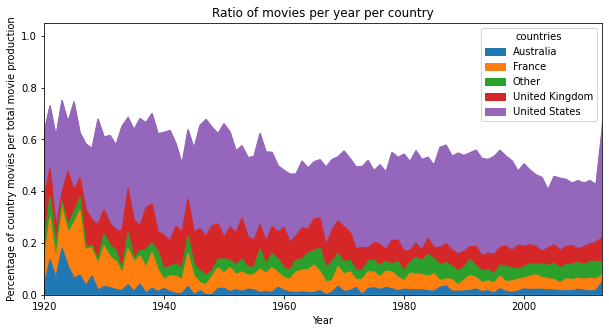

In [33]:
# select number of most popular countries to display
nbr_countries = 5

# Create a pivot table with the number of movies per country per year
pt_prod = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['production'], aggfunc=np.sum)

# Scale the data by the total number of movies per year
pt_prod = pt_prod.divide(pt_prod.sum(axis='columns'), axis='index')

# Select the top nbr_countries countries and plot the data
s = pt_prod.sum(axis = 'index')
indx = list(s.sort_values(ascending=False).index[:nbr_countries].get_level_values('countries'))
pt_prod.columns = pt_prod.columns.get_level_values('countries')
pt_prod = pt_prod[np.intersect1d(pt_prod.columns, indx)]

pt_prod.fillna(0).plot.area(stacked=True, figsize=(10, 5), xlim=(1920, 2013), xlabel='Year', ylabel='Percentage of country movies per total movie production', title='Ratio of movies per year per country')

<AxesSubplot:title={'center':'Average sentiment per year per country'}, xlabel='Year', ylabel='Average sentiment'>

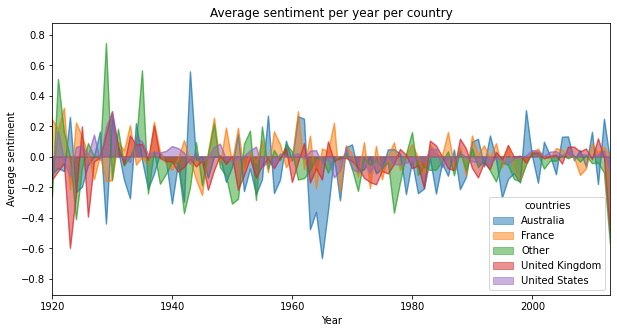

In [34]:
# Plot the average sentiment per country per year, using the phrase sentiment as a proxy for the country sentiment

pt_c_sent = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['country_sentiment'], aggfunc=np.mean)
pt_c_sent.columns = pt_c_sent.columns.get_level_values('countries')
pt_c_sent = pt_c_sent[np.intersect1d(pt_c_sent.columns, indx)]

pt_c_sent.fillna(0).plot.area(stacked=False, figsize=(10, 5), xlim=(1920, 2013), xlabel='Year', ylabel='Average sentiment', title='Average sentiment per year per country')

<AxesSubplot:title={'center':'Average sentiment per year per country'}, xlabel='Year', ylabel='Average sentiment'>

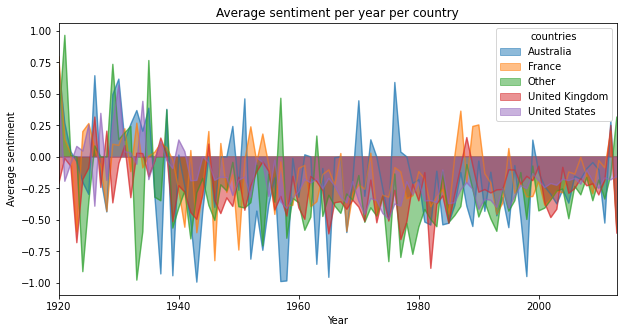

In [35]:
# Plot the average sentiment per country per year, using the summary sentiment as a proxy for the country sentiment

pt_g_sent = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['general_sentiment'], aggfunc=np.mean)
pt_g_sent.columns = pt_g_sent.columns.get_level_values('countries')
pt_g_sent = pt_g_sent[np.intersect1d(pt_g_sent.columns, indx)]

pt_g_sent.fillna(0).plot.area(stacked=False, figsize=(10, 5), xlim=(1920, 2013), xlabel='Year', ylabel='Average sentiment', title='Average sentiment per year per country')

## Sentiment decision

From the two plots above, we can see that the general sentiment of the movies follow a stronger pattern. Common sense also made us lean towards general movie sentiment since The specific phrase where a country is mentioned may not always show the general sentiment given by the movie to that country.

The fact that the sentiment is less strong for these phrases is because Vader has more trouble finding the sentiment of small texts and the cumulative score given is often 0.

Since we are only interested in the difference in movie production per country and not the difference between countries, we did not set the same y axis for all the countries.

In [9]:
# Select countries to plot
country_list = ["Iraq", "Iran", "Afghanistan", "Vietnam", "Algeria", "Russia", "France", "Germany", "United States"]
# Define major wor periods for each country
war_dates = [
    [[1980, 1988], [1990, 1991], [2003, 2011]], # Iraq
    [[1980, 1988], [1963, 1978]], # Iran
    [[1979, 1989], [2001, 2021]], # Afghanistan
    [[1955, 1975], [1977, 1991], [1979, 1980]], # Vietnam
    [[1939, 1945], [1954, 1962]], # Algeria
    [[1939, 1945], [1947, 1991], [1979, 1989]], # Russia
    [[1939, 1945], [1954, 1962]], # France
    [[1939, 1945]], # Germany
    [[1939, 1945], [1947, 1991], [1955, 1975], [2003, 2011], [1979, 1989]], # United States
    ]

# Prepare data for plotting as done before
pt_prod = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['production'], aggfunc=np.sum)
pt_g_sent = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['general_sentiment'], aggfunc=np.mean)
pt_prod.columns = pt_prod.columns.get_level_values('countries')
pt_g_sent.columns = pt_g_sent.columns.get_level_values('countries')

pt_prod = pt_prod.divide(pt_prod.sum(axis='columns'), axis='index')


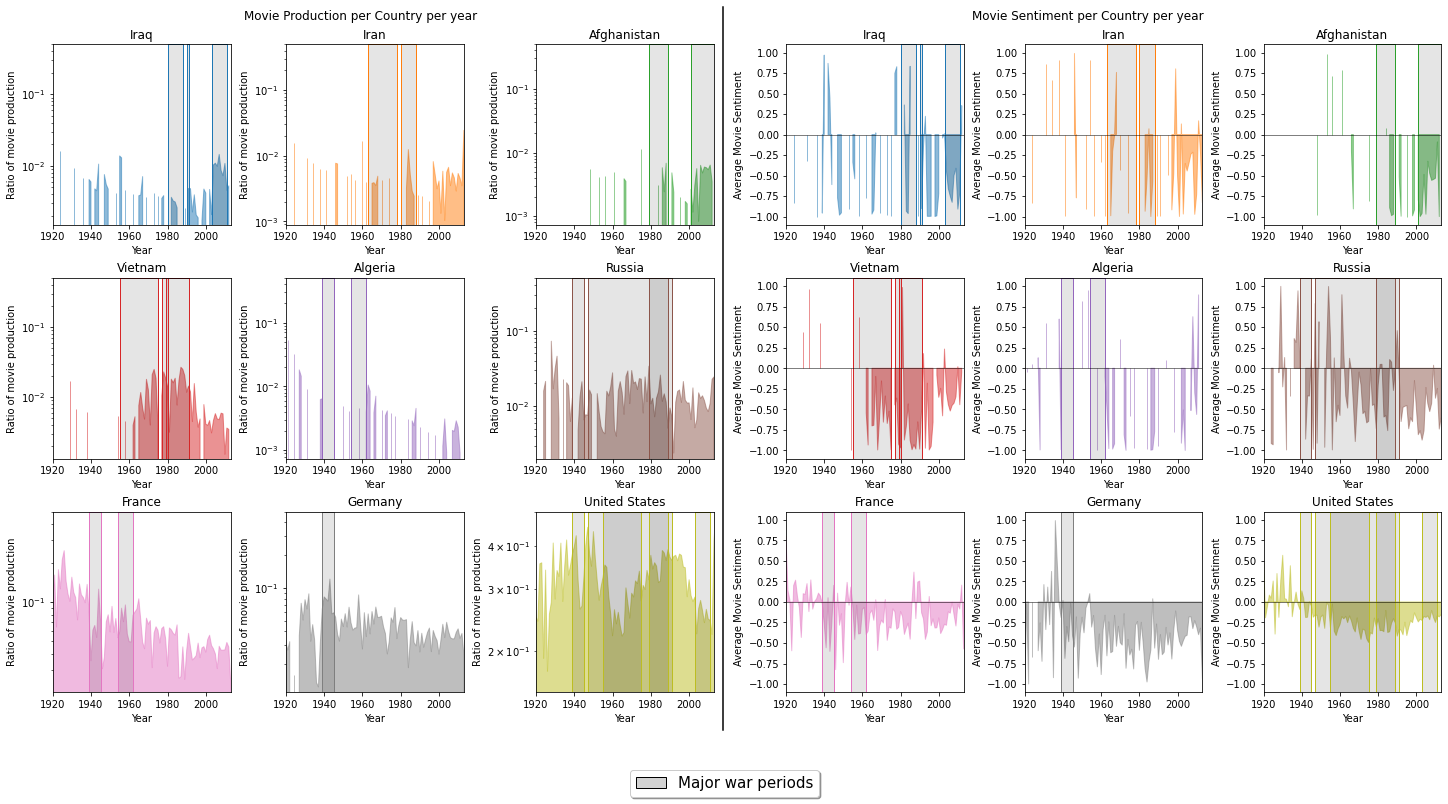

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(20, 10)) 

# Create a grid of two subplots
subfigs = fig.subfigures(1, 2)
subfigs_flat = subfigs.flat
subfigs_flat[0].suptitle("Movie Production per Country per year", fontsize='large')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Divide the subplot into a 3x3 grid
axs = subfigs_flat[0].subplots(3, 3)

# Iterate over the grids and plot the production data for each country
for innerind, ax in enumerate(axs.flat):

    ax.set_title(country_list[innerind])
    ax.fill_between(pt_prod.index, pt_prod[country_list[innerind]], alpha=0.5, color = color_cycle[innerind])
    ax.set_yscale('log')
    ax.set_xlim(1920, 2013)
    ax.set_ylim(None,0.5)
    ax.set_xlabel("Year")
    ax.set_ylabel("Ratio of movie production")

    # Add the war rectangles
    for i, war in enumerate(war_dates[innerind]):
        rect_fill = patches.Rectangle((war[0], 0), war[1]-war[0], 0.5,
         linewidth=1, edgecolor='black', facecolor='black', alpha=0.1)
         
        rect_outline = patches.Rectangle((war[0], 0), war[1]-war[0], 0.5,
         linewidth=1, edgecolor=color_cycle[innerind], facecolor='none', alpha=1)

        ax.add_patch(rect_fill)
        ax.add_patch(rect_outline)

# Plot a black line separating the two subplots
axs.flat[5].plot([1.05, 1.05], [2.5, -1.5], transform=axs.flat[5].transAxes, clip_on=False, color = 'black')

# Divide the subplot into a 3x3 grid and name it
subfigs_flat[1].suptitle("Movie Sentiment per Country per year", fontsize='large')
axs = subfigs_flat[1].subplots(3, 3)

# Iterate over the grids and plot the sentiment data for each country
for innerind, ax in enumerate(axs.flat):

    ax.set_title(country_list[innerind])
    ax.fill_between(pt_g_sent.index, pt_g_sent[country_list[innerind]], alpha=0.5, color = color_cycle[innerind])
    ax.set_xlim(1920, 2013)
    ax.set_ylim(-1.1,1.1)
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Movie Sentiment")
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    # Add the war rectangles
    for i, war in enumerate(war_dates[innerind]):
        rect_fill = patches.Rectangle((war[0], -1.1), war[1]-war[0], 2.2,
         linewidth=1, edgecolor='black', facecolor='black', alpha=0.1)
         
        rect_outline = patches.Rectangle((war[0], -1.1), war[1]-war[0], 2.2,
         linewidth=1, edgecolor=color_cycle[innerind], facecolor='none', alpha=1)
        ax.add_patch(rect_fill)
        ax.add_patch(rect_outline)

# Add a legend to the bottom of the figure
gray_patch = patches.Patch(edgecolor='Black', facecolor='lightgray', label='Major war periods')
fig.legend(handles=[gray_patch], loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, prop={'size': 15})

plt.show()

## Advanced Interactive plots

Now that we have the data we want to present, we can start working on our interactive plots.

The first plot will be a stacked area plot showing the ratio of movies per year that have a positive or negative sentiment.

In [16]:
# Define sentiment threshold for positive and negative sentiment
sentiment_threshhold = 0.2

# Create a new column for positive and negative sentiment
df_summaries_dated['pos'] = df_summaries_dated['general_sentiment'] > sentiment_threshhold
df_summaries_dated['neg'] = (-1)*(df_summaries_dated['general_sentiment'] < -sentiment_threshhold)

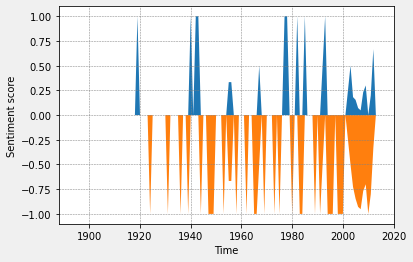

In [17]:
# Format data and generate a preliminary subplot so see if the output is correct

pt_prod_pos = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['pos'], aggfunc=np.sum)
pt_prod_neg = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['neg'], aggfunc=np.sum)
pt_prod = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['production'], aggfunc=np.sum)

pt_prod_pos.columns = pt_prod_pos.columns.get_level_values('countries')
pt_prod_neg.columns = pt_prod_neg.columns.get_level_values('countries')
pt_prod.columns = pt_prod.columns.get_level_values('countries')

pt_prod_pos = pt_prod_pos.divide(pt_prod, axis='index').fillna(0)
pt_prod_neg = pt_prod_neg.divide(pt_prod, axis='index').fillna(0)

fig, ax = plt.subplots(nrows=1, ncols=1, facecolor="#F0F0F0")
ax.stackplot(pt_prod_pos.index, pt_prod_pos.Iraq)
ax.stackplot(pt_prod_pos.index, pt_prod_neg.Iraq)

ax.set_xlabel("Time")
ax.set_ylabel("Sentiment score")
ax.grid(which="major", color="grey", linestyle="--", linewidth=0.5)

plt.show()

### Region Analysis

In order to get a better idea of movies, we will join countries by region, that way we can see how wart affects our vision of a whole region of the world.

In [21]:
# Load our table with all countries and their corresponding region
region_map = pd.read_csv('./data/country_regions.csv',sep=",", header=0)

In [22]:
# Create a list with all the different regions and find their coordinates
location_region_map = pd.DataFrame(region_map['region'].unique(), columns =['region'])
location_region_map['address'] = location_region_map['region'].apply(geocode)
location_region_map['coordinates'] = location_region_map['address'].apply(lambda loc: tuple(loc.point) if loc else None)

KeyboardInterrupt: 

In [ ]:
# Create a list with all the different countries and find their coordinates
location_country_map = pd.DataFrame(df_summaries_dated['countries'].unique(), columns =['countries'])
location_country_map['address'] = location_country_map['countries'].apply(geocode)
location_country_map['coordinates'] = location_country_map['address'].apply(lambda loc: tuple(loc.point) if loc else None)

In [ ]:
# Extract the latitude and longitude from the country coordinates and add them to the dataframe matching the corresponding country
location_country_map[['latitude', 'longitude', 'altitude']] = pd.DataFrame(location_country_map['coordinates'].tolist(), index=location_country_map.index)
location_country_map.latitude.isnull().sum()
location_country_map = location_country_map[pd.notnull(location_country_map['latitude'])]

df_summaries_coordinates = df_summaries_dated.copy()
df_summaries_coordinates = pd.merge(df_summaries_coordinates, location_country_map, on = 'countries')

In [ ]:
# Extract the latitude and longitude from the region coordinates and add them to the dataframe matching the corresponding region
location_region_map[['latitude', 'longitude', 'altitude']] = pd.DataFrame(location_region_map['coordinates'].tolist(), index=location_region_map.index)
location_region_map.latitude.isnull().sum()
location_region_map = location_region_map[pd.notnull(location_region_map['latitude'])]

df_summaries_region = df_summaries_dated.copy()
df_summaries_region['region'] = df_summaries_region['countries'].map(region_map.set_index('countries')['region'])
df_summaries_region = pd.merge(df_summaries_region, location_region_map, on = 'region')

In [ ]:
# Save regions and country dataframe to make loading faster in the future
df_summaries_region.to_csv('df_summaries_region.csv')
df_summaries_coordinates.to_csv('df_summaries_coordinates.csv')

In [11]:
# Load the dataframes
df_summaries_region = pd.read_csv('df_summaries_region.csv', index_col=0)
df_summaries_coordinates = pd.read_csv('df_summaries_coordinates.csv', index_col=0)

# Create a new column for positive and negative sentiment of regions, and normalize the sentiment score by country production
df_region_grouped = df_summaries_region.groupby(['Movie_release', 'region']).sum().reset_index()
df_region_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']] = \
    df_region_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']].div(df_region_grouped['production'], axis=0)

# Normalise the production by year to get the percentage of production compared to the total world production
prod_by_year = df_region_grouped.groupby(['Movie_release']).sum().reset_index()
df_region_grouped['production'] /= df_region_grouped['Movie_release'].map(prod_by_year.set_index('Movie_release')['production'])

# Create a new column for positive and negative sentiment of countries, and normalize the sentiment score by country production
df_country_grouped = df_summaries_region.groupby(['Movie_release', 'countries']).sum().reset_index()
df_country_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']] = \
    df_country_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']].div(df_country_grouped['production'], axis=0)

# Normalise the production by year to get the percentage of production compared to the total world production
df_country_grouped['production'] /= df_country_grouped['Movie_release'].map(prod_by_year.set_index('Movie_release')['production'])


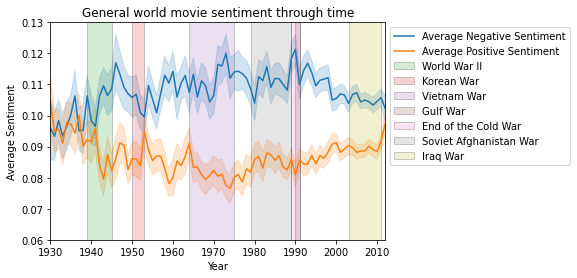

In [12]:
war_names = ['World War II', 'Korean War', 'Vietnam War', 'Gulf War', 'End of the Cold War', 'Soviet Afghanistan War', 'Iraq War']
war_dates = [[1939, 1945], [1950, 1953], [1964, 1975], [1990, 1991], [1989, 1991], [1979, 1989], [2003, 2011]]

sns.lineplot(x="Movie_release", y="negative_sentiment", data=df_summaries_dated, label="Average Negative Sentiment")
sns.lineplot(x="Movie_release", y="positive_sentiment", data=df_summaries_dated, label="Average Positive Sentiment")

for i, war in enumerate(war_dates):
        rect_fill = patches.Rectangle((war[0], 0), war[1]-war[0], 1,
         linewidth=1, edgecolor='black', facecolor=color_cycle[i + 2], alpha=0.2, label=war_names[i])

        plt.gca().add_patch(rect_fill)

plt.ylim(0.06, 0.13)
plt.xlim(1930, 2012)
plt.title("General world movie sentiment through time")
plt.xlabel("Year")
plt.ylabel("Average Sentiment")
plt.legend( loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [27]:
# initialise color chart to use for the plots
color_chart = px.colors.qualitative.Plotly

# Define the list of countries that will be in the checklist, and the ones that start checked
country_checklist = [['United States', 'United Kingdom', 'France', 'India', 'Germany', 'Australia', 'Italy', 'China', 'Japan', 'Canada', 'Mexico', 'Spain', 'Russia', 'Iraq', 'Vietnam', 'Netherlands', 'Austria', 'Luzon', 'Turkey', 'Switzerland', 'South Korea', 'Brazil', 'Poland', 'Sweden', 'Egypt_prod', 'Israel', 'Argentina', 'Afghanistan', 'New Zealand'],
 ['Vietnam', 'Afghanistan', 'Iraq']]

# Define the list of regions that will be in the checklist, and the ones that start checked
region_checklist = [[
'Middle East',
'Soviet union',
'Africa',
'Oceania',
'PIGS',
'North America',
'Latin America',
'Continental Europe',
'South Asia',
'South East Asia',
'East Asia',
'North Asia',
'Scandinavia',], ['South Asia', 'Middle East', 'Continental Europe']]

# Create the app
app_areaplot = JupyterDash(__name__)

# Define the layout of the app in html
app_areaplot.layout = html.Div([
    html.H4("Country's key performance analytics"),
    html.P("Select country or region mode."),
    dcc.Dropdown(
        id='country_continent',
        options=['Country', 'Regions'],
        value='Country'
    ),
    html.P("Select desired countries.", id = "country_continent_text"),
    dcc.Checklist([],[],
      id='checklist',
      labelStyle={'display': 'block'},
      style={'columnCount': 7}
      ),
    html.P("Select sentiment or movie production analysis."),
    dcc.Dropdown(
        id='sentiment_prod',
        options=['Sentiment', 'Production'],
        value='Sentiment'
    ),
    dcc.Graph(id="graph"),
])

# Define the callback to change the checklist depending on the mode selected
@app_areaplot.callback(
    [Output("checklist", 'options'),
    Output("checklist", 'value'),
    Output("country_continent_text", "children"), ],
    Input("country_continent", "value"))
def change_mode(contry_continent):
    if contry_continent == "Country":
        
        text = "Select desired countries."
        return country_checklist[0], country_checklist[1], text
    else :
        
        text = "Select desired regions."
        return region_checklist[0], region_checklist[1], text

# Define the callback to change the graph depending on the mode selected
@app_areaplot.callback(
    Output("graph", "figure"),  
    [Input("country_continent", "value"),
    Input("checklist", "value"),
    Input("sentiment_prod", "value")])
def display_area(contry_continent, checks, sentiment_prod):
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    df = pd.DataFrame()
    
    # define the dataframe to use depending on the mode selected
    if contry_continent == "Country":
        mode = "countries"
        df = df_country_grouped[df_country_grouped[mode].isin(checks)].fillna(0)
    else :
        mode = "region"
        df = df_region_grouped[df_region_grouped[mode].isin(checks)].fillna(0)

    # If the sentiment analysis is selected, plot the sentiment score in symmetric stacked area plots
    if sentiment_prod == "Sentiment":
        axis_label = "Average positive(y>0) and negative(y<0) <br> sentiment score."
        # Iterate through selected countries or regions
        for i, c in enumerate(checks):
            
            # Plot the positive sentiment score
            fig.add_trace(go.Scatter(
                name = c,
                x = df[df[mode] == c]["Movie_release"],
                y = df[df[mode] == c]["pos"],
                line_color= color_chart[i],
                fillcolor= color_chart[i],
                legendgroup= i,
                stackgroup='one',
            ))
            # Plot the negative sentiment score
            fig.add_trace(go.Scatter(
                name = c,
                x = df[df[mode] == c]["Movie_release"],
                y = df[df[mode] == c]["neg"],
                line_color= color_chart[i],
                fillcolor= color_chart[i],
                legendgroup= i,
                showlegend=False,
                stackgroup='two'
            ))
    # If the production analysis is selected, plot the production in stacked area plots
    else :
        axis_label = "Ratio of movies produced in a country <br> by total productions."

        # Iterate through selected countries or regions
        for c in checks:
            # Plot the production per year
            fig.add_trace(go.Scatter(
                name = c,
                x = df[df[mode] == c]["Movie_release"],
                y = df[df[mode] == c]["production"],
                showlegend=True,
                legendgroup= 0,
                stackgroup='three'
            ))
    # Define the layout of the graph and the tiles
    fig.update_layout(
    title="Evolution of movie " + str(sentiment_prod) + " by " + str(contry_continent),
    xaxis_title="Year",
    yaxis_title= axis_label,
    legend_title=str(contry_continent),
    )

    # Add a horizontal line at y=0
    fig.add_hline(y=0, line_width=1, line_color="black")
    
    return fig


In [28]:
# Run the app
app_areaplot.run_server(mode = "inline")

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
IndexError: list index out of range

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
IndexError: list index out of range

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
IndexError: list index out of range

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
IndexError: list index out of range

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
IndexError: list index out of range

-------------------------------------------------------

## Map Generation

We also decided to make an interactive display to look at the production and sentiment of movies in the word depending on the year, and plot them in an interactive map.

In [11]:
# Create a JSON string in the geojson format for the map   
feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

# Loop through the rows of the DataFrame
for _, row in df_summaries_coordinates.iterrows():
    # Create a feature for each country and year
    feature = {
        'type': 'Feature',
        'properties': {
            'time': row['Movie_release'],
            'descript_prodion': row['countries'],
            'sentiment':row['general_sentiment'],
            'name': row['Movie_name_y'],
        },
        'geometry': {
            'type': 'Point',
            'coordinates': [row['longitude'], row['latitude']]
        }
    }

    # Add the feature to the feature collection
    feature_collection['features'].append(feature)

In [21]:
# Define the year and the range displayed on the sliders
slider_year = 2000
range_year = 1995

# Define the map type
card_type = dl.TileLayer(
                            url='https://tiles.stadiamaps.com/tiles/alidade_smooth_dark/{z}/{x}/{y}{r}.png',
                            attribution='&copy; <a href="https://stadiamaps.com/">Stadia Maps</a>, &copy; <a href="https://openmapt_prodiles.org/">OpenMapt_prodiles</a> &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors',
                        )

# Format the dataset to be used in the map
df_summaries_coordinates = df_summaries_coordinates[df_summaries_coordinates['Movie_release'] >= 1900]
df_summaries_coordinates=df_summaries_coordinates.dropna(subset=['countries','latitude'])

# Define color scale gradient
colorscale = ['red', 'yellow', 'green']

# Define the color scale
chroma = "https://cdnjs.cloudflare.com/ajax/libs/chroma-js/2.1.0/chroma.min.js"  # js lib used for colors
color_prop = 'general_sentiment' # property to color by

# Create a colorbar for the sentiment score
vmax = 1
vmin = -1
colorbar = dl.Colorbar(colorscale=colorscale, width=20, height=150, min=-1, max=1, unit=' sentiment score', style= {'color': 'white'})


# Javascript code for Geojson rendering logic

point_to_layer = assign("""
function(feature, latlng, context){
    const {min, max, colorscale, circleOptions, colorProp} = context.props.hideout;
    const csc = chroma.scale(colorscale).domain([min, max]);  // chroma lib to construct colorscale
    circleOptions.fillColor = csc(feature.properties[colorProp]);  // set color based on color prop.
    return L.circleMarker(latlng, circleOptions);  // sender a simple circle marker.
}""")

cluster_to_layer = assign("""function(feature, latlng, index, context){
    const {min, max, colorscale, circleOptions, colorProp} = context.props.hideout;
    const csc = chroma.scale(colorscale).domain([min, max]);

    // Set color based on mean value of leaves.
    const leaves = index.getLeaves(feature.properties.cluster_id);
    let valueSum = 0;
    for (let i = 0; i < leaves.length; ++i) {
        valueSum += leaves[i].properties[colorProp]
    }
    const valueMean = valueSum / leaves.length;
    
    // Render a circle with the number of leaves written in the center.
    const icon = L.divIcon.scatter({
        html: '<div style="background-color:white;"><span>' + feature.properties.point_count_abbreviated + '</span></div>',
        className: "marker-cluster",
        iconSize: L.point(40, 40),
        color: csc(valueMean)
    });
    return L.marker(latlng, {icon : icon})
}""")


In [22]:
def get_data(subset:object)->list:
    """ Returns the map layout and the data to be displayed on the map from the input subset.
    Args:
        x (object): dataframe subset to be displayed on the map

    Returns:
        card_type: The background map type
        geojson: The data to be displayed on the map
        colorbar: The colorbar to be displayed on the map
    """

    # Pre process the data into geobuf.
    dicts = subset.to_dict('rows')

    # Add tooltip to each point. The tooltip is the name of the country, the sentiment and the year.
    for row in dicts:
        row["tooltip"] = "{} ({:.1f})".format(str(int(row['Movie_release'])) + ',  ' + row['Movie_name_y'] + ' ', row[color_prop])  # bind tooltip

    geojson = dlx.dicts_to_geojson(dicts, lon="longitude", lat = "latitude")  # convert to geojson
    geobuf = dlx.geojson_to_geobuf(geojson)  # convert to geobuf

    # Create geojson.
    geojson = dl.GeoJSON(data=geobuf, id="geojson", format="geobuf",
                        zoomToBounds=False,  # when true, zooms to bounds when data changes
                        cluster=True,  # when true, data are clustered
                        clusterToLayer=cluster_to_layer,  # how to draw clusters
                        zoomToBoundsOnClick=True,  # when true, zooms to bounds of feature (cluster, marker, etc.) on click
                        options=dict(pointToLayer=point_to_layer),  # how to draw points
                        superClusterOptions=dict(radius=120),   # adjust cluster size
                        hideout=dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=5),
                                    min=vmin, max=vmax, colorscale=colorscale)) # hideout is used in the point_to_layer function

    return [card_type, geojson, colorbar]

In [23]:
# Create the app.
app = JupyterDash(external_scripts=[chroma], prevent_initial_callbacks=True)

##########################

# Create the map htmp layer with initial values
map_layer = html.Div([

    dl.Map(get_data(df_summaries_coordinates[df_summaries_coordinates['Movie_release'].between(range_year, slider_year)]),

     id='world_map', zoom = 4, center=(40.0884, -3.68042)),

], style={'width': '100%', 'height': '80vh', 'margin': "auto", "display": "block", "position": "relative"})

# Create the app layout in html format
app.layout = html.Div([
    html.P("Select Year Range to analyze the sentiment and filming location of the movies in those years."),

    dcc.Checklist(
    ['Fixed Range'],
    [],
    id='fixed_range',
    ),

    dcc.RangeSlider(min=1900, max=2015,
      step=1, value=[range_year, slider_year],
      marks={i: '{}'.format(i) for i in range(1900, 2015, 5)},
      tooltip={"placement": "bottom", "always_visible": True},
      id='range_slider',
    ),
      
    map_layer
])

# Create global variables to store the range difference, used when the fixed range is selected.
range_difference = 5

# app callback to update the map when the slider is moved.
@app.callback(
    [Output("world_map", "children"),
    Output("range_slider", "value")],

    [Input("range_slider", "value"),
    Input("fixed_range", "value")],)
def display_area(year_range, fixed_value):

    global slider_year
    global range_difference
    new_range = []

    # If the fixed range is not selected, return the data subset for the selected range.
    if len(fixed_value) == 0 :
        range_difference = year_range[1] - year_range[0]
        return get_data(df_summaries_coordinates[df_summaries_coordinates['Movie_release'].between(year_range[0], year_range[1])]), [year_range[0], year_range[1]]

    # If the fixed range is selected, move the sliders accordingly and return the data subset for the new range.
    else:
        # If the slider is moved to the right, move the range to the right.
        if slider_year != year_range[0] :
            new_range = [year_range[0], year_range[0] + range_difference]
            slider_year = new_range[0]

        # If the slider is moved to the left, move the range to the left.
        elif slider_year + range_difference != year_range[1] :
            new_range = [year_range[1] - range_difference, year_range[1]]
            slider_year = new_range[0]
        # Return the data subset for the new range.
        return get_data(df_summaries_coordinates[df_summaries_coordinates['Movie_release'].between(new_range[0], new_range[1])]), [new_range[0], new_range[1]]


C:\Users\nicte\AppData\Local\Temp/ipykernel_2044/2789880619.py:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  dicts = subset.to_dict('rows')


In [24]:
# Run the app.
app.run_server(mode='inline', port=8060)

C:\Users\nicte\AppData\Local\Temp/ipykernel_2044/2789880619.py:13: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.

